In [13]:
!pip install ucimlrepo

In [25]:
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [26]:
# Step 1: Fetch the dataset
breast_cancer = fetch_ucirepo(id=14)

# Step 2: Extract features and target variables
X = breast_cancer.data.features
y = breast_cancer.data.targets['Class']  # Extract 'Class' as a Series

# Print metadata and variable information
print(breast_cancer.metadata)
print(breast_cancer.variables)

{'uci_id': 14, 'name': 'Breast Cancer', 'repository_url': 'https://archive.ics.uci.edu/dataset/14/breast+cancer', 'data_url': 'https://archive.ics.uci.edu/static/public/14/data.csv', 'abstract': 'This breast cancer domain was obtained from the University Medical Centre, Institute of Oncology, Ljubljana, Yugoslavia. This is one of three domains provided by the Oncology Institute that has repeatedly appeared in the machine learning literature. (See also lymphography and primary-tumor.)', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 286, 'num_features': 9, 'feature_types': ['Categorical'], 'demographics': ['Age'], 'target_col': ['Class'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1988, 'last_updated': 'Thu Mar 07 2024', 'dataset_doi': '10.24432/C51P4M', 'creators': ['Matjaz Zwitter', 'Milan Soklic'], 'intro_paper': None, 'additional_info': {'summary': 'Thi

In [27]:
# Step 3: Preprocess the data
# Handle missing values: for simplicity, let's drop rows with missing values
X = X.replace('?', np.nan)  # Replace '?' with NaN
X = X.dropna()  # Drop rows with missing values

# Since we dropped rows, ensure y corresponds to the modified X
y = y.loc[X.index]

# Convert categorical variables to dummy variables
X = pd.get_dummies(X, drop_first=True)

# Encode the target variable if it's categorical
le = LabelEncoder()
y = le.fit_transform(y)

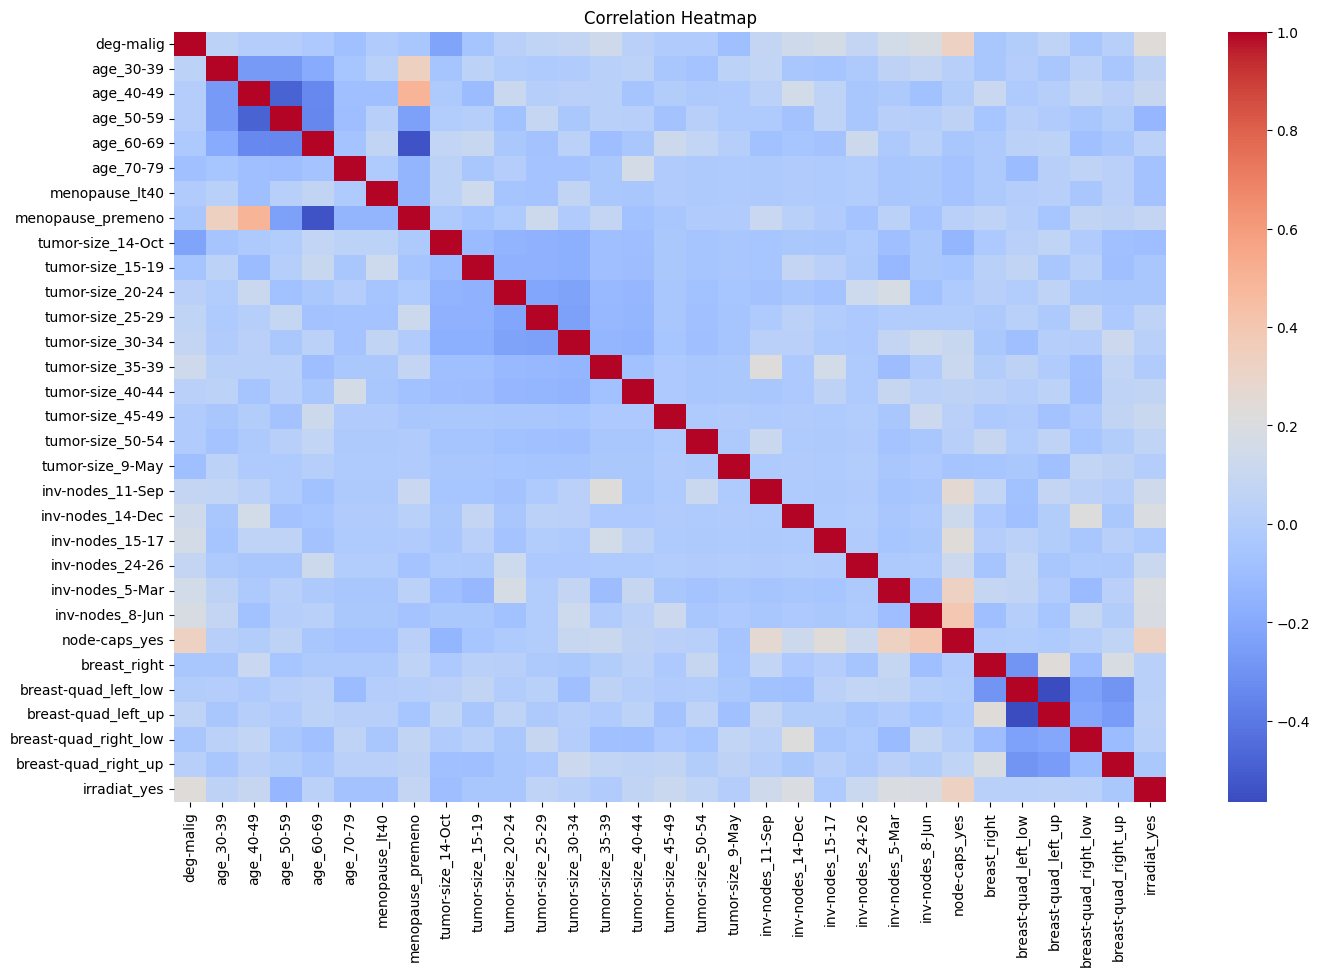

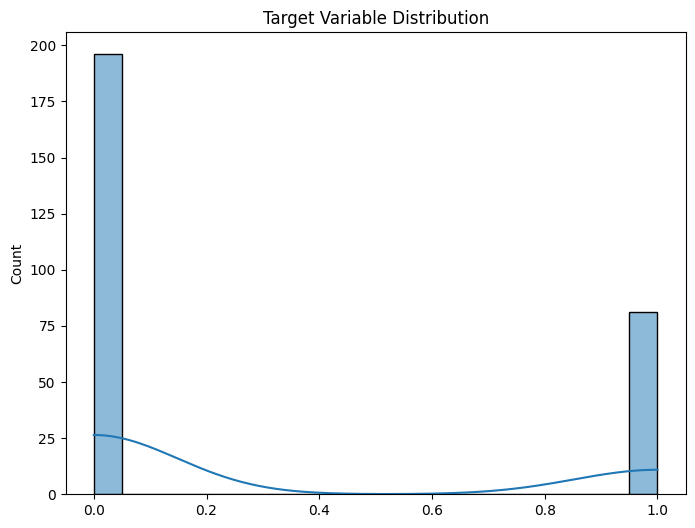

In [28]:
# Visualize correlations with a heatmap
plt.figure(figsize=(16, 10))
correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

# Visualize distribution of the target variable
plt.figure(figsize=(8, 6))
sns.histplot(y, kde=True, bins=20)
plt.title("Target Variable Distribution")
plt.show()

In [29]:
# Step 4: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Helper function to create a model pipeline
def build_model(model):
    pipeline = Pipeline([
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('scaler', StandardScaler()),
        ('regressor', model)
    ])
    return pipeline

# Initialize models
models = {
    "Lasso Regression": Lasso(alpha=0.1),
    "ElasticNet Regression": ElasticNet(alpha=0.1, l1_ratio=0.5)
}

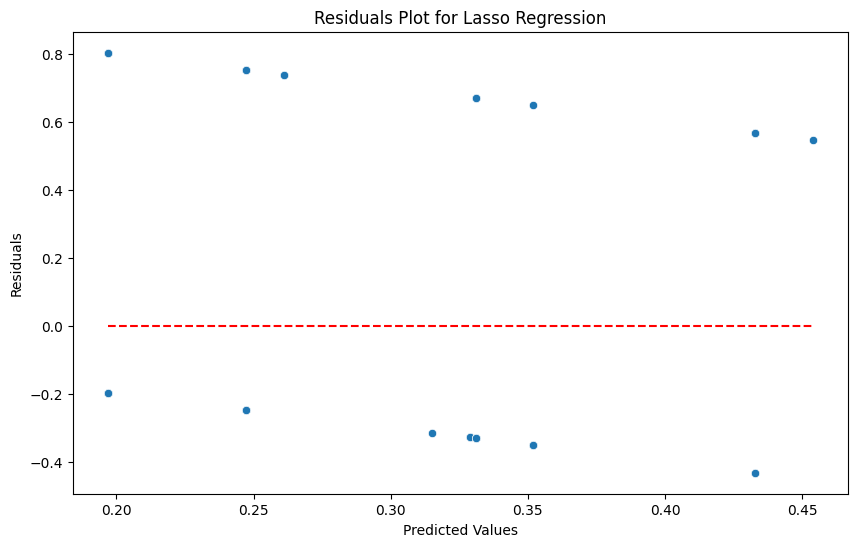

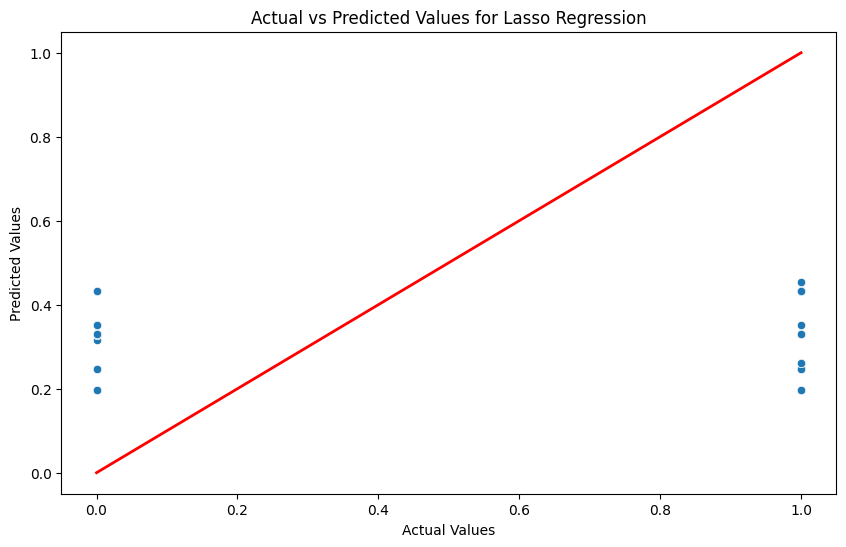

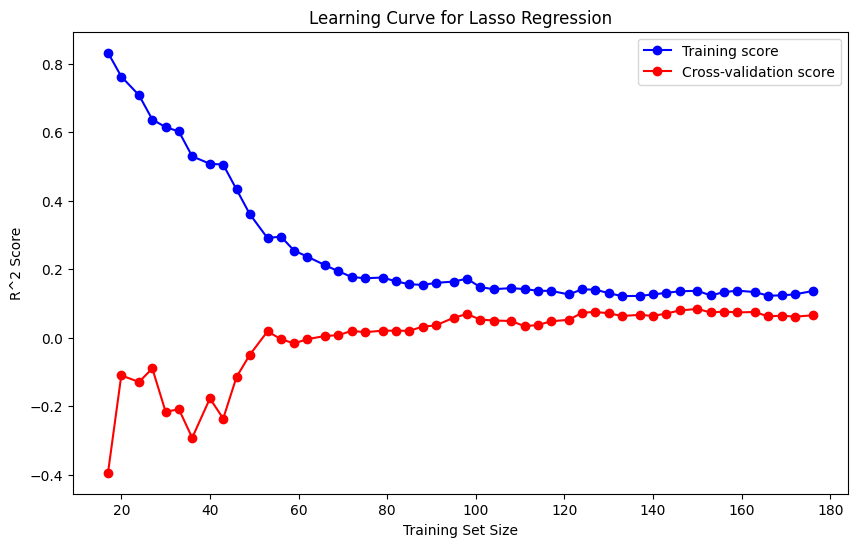

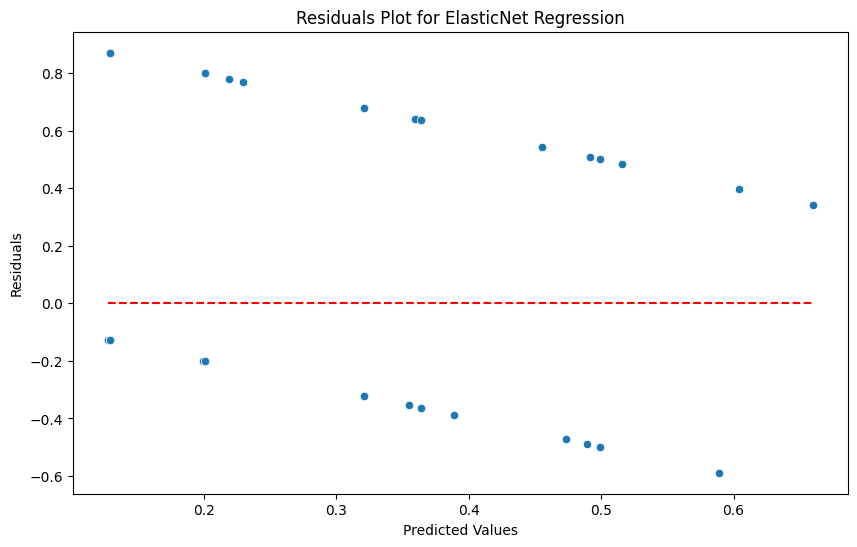

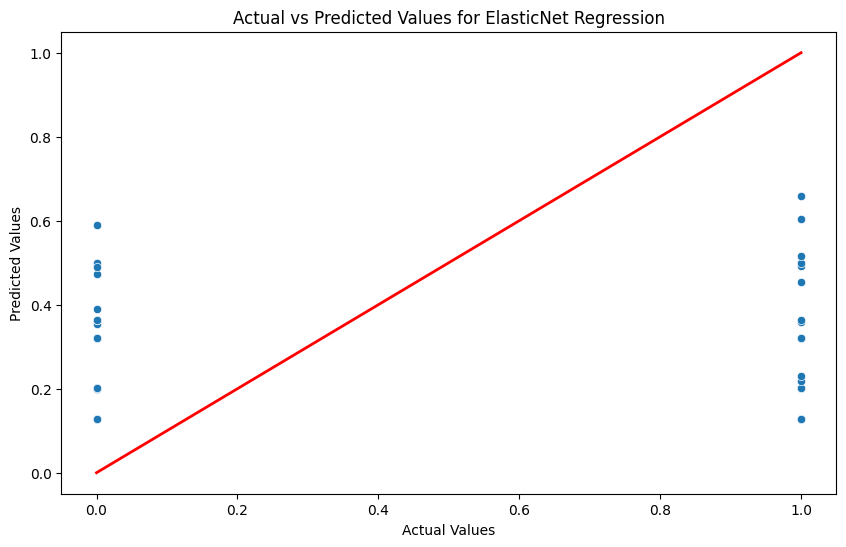

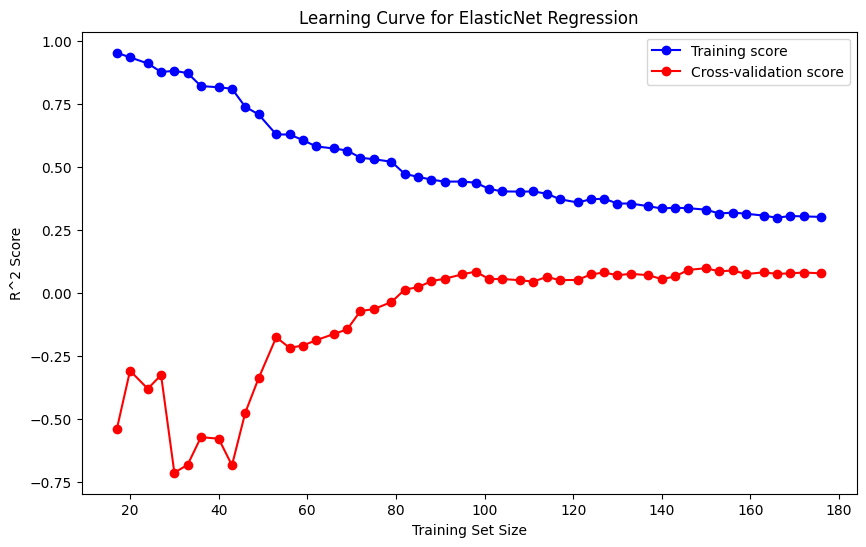

In [30]:
# Step 5: Train models and evaluate metrics
for name, model in models.items():
    # Train the model
    pipeline = build_model(model)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    cross_val_r2 = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2').mean()

    # Residuals Plot
    residuals = y_test - y_pred
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_pred, y=residuals)
    plt.hlines(y=0, xmin=min(y_pred), xmax=max(y_pred), colors='red', linestyles='dashed')
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.title(f"Residuals Plot for {name}")
    plt.show()

    # Prediction vs Actual Plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_test, y=y_pred)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"Actual vs Predicted Values for {name}")
    plt.show()

    # Learning Curve Plot
    train_sizes, train_scores, test_scores = learning_curve(
        pipeline, X_train, y_train, cv=5, scoring='r2', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 50))

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='red', label='Cross-validation score')
    plt.title(f"Learning Curve for {name}")
    plt.xlabel("Training Set Size")
    plt.ylabel("R^2 Score")
    plt.legend(loc="best")
    plt.show()


In [31]:
    # Print metrics
    print(f"{name} Metrics:")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"R^2 Score: {r2}")
    print(f"Cross-Validation R^2 Score: {cross_val_r2}")
    print("-" * 40)

ElasticNet Regression Metrics:
Mean Squared Error (MSE): 0.20875127617503522
Root Mean Squared Error (RMSE): 0.45689306864411416
Mean Absolute Error (MAE): 0.3884305796864785
R^2 Score: 0.0687852032931573
Cross-Validation R^2 Score: 0.07297391084516033
----------------------------------------
